In [2]:
import os
import pandas as pd
import geopandas as gpd

In [98]:
gdf = gpd.read_feather(r"E:\client_v2_data\WB_country_IDs.feather")
gdf.columns = [col.lower() for col in gdf.columns]

In [6]:
path = r"Z:\Laboral\World Bank\CLIENT v2\Data\Data_proc\shocks"
files = os.listdir(path)
files = [f for f in files if f.endswith('.parquet')]

In [7]:
def parse_filename(f):
    f = f.split('_')
    return {
        'variable': f[1],
        'threshold': f"{f[2]}_{f[3]}",
        'year': f[4],
        'chunk': f[5]
    }
parse_filename(files[10000])

{'variable': 'SPEI-3', 'threshold': '1_5', 'year': '1973', 'chunk': '5'}

In [13]:
def process_chunk(df):
    df = df.reset_index(names=["ID"])
    df["threshold"] = df["threshold"].str.replace("_", "")
    df["variable"] = df["variable"].str.replace("-", "")
    df["name"] = df["variable"].str.lower() + df["threshold"].astype(str)
    df = df.drop(columns=["area_affected", "population_affected","variable", "threshold", "chunk"])
    return df

df = pd.read_parquet(os.path.join(path, f))
# Agrego como cols la variable, threshold, year y chunk
names = parse_filename(f)
df[list(names.keys())] = list(names.values())
process_chunk(df)


,ID,cells_affected,total_cells,population_affected_n,total_population,year,name
0,0.0,0,24,0,0,1970,spei1210
1,2.0,0,40,0,0,1970,spei1210
2,3.0,0,148,0,0,1970,spei1210
3,4.0,0,154,0,0,1970,spei1210
4,5.0,0,80,0,0,1970,spei1210
...,...,...,...,...,...,...,...
8898,38145.0,0,570,0,0,1970,spei1210
8899,38146.0,0,4664,0,0,1970,spei1210
8900,38147.0,0,980,0,0,1970,spei1210
8901,38148.0,0,9261,0,0,1970,spei1210


In [15]:
from tqdm import tqdm

dfs = []
for f in tqdm(files):
    df = pd.read_parquet(os.path.join(path, f))
    # Agrego como cols la variable, threshold, year y chunk
    names = parse_filename(f)
    df[list(names.keys())] = list(names.values())
    # Proceso el chunk
    dfs += [process_chunk(df)]

100%|██████████| 30600/30600 [12:01<00:00, 42.44it/s]


In [17]:
df = pd.concat(dfs)

In [20]:
df = df.groupby(["ID", "name", "year"]).sum()
df["area_affected"] = df["cells_affected"] / df["total_cells"]
df["population_affected"] = df["population_affected_n"] / df["total_population"]

Text(0.5, 1.0, 'Area affected')

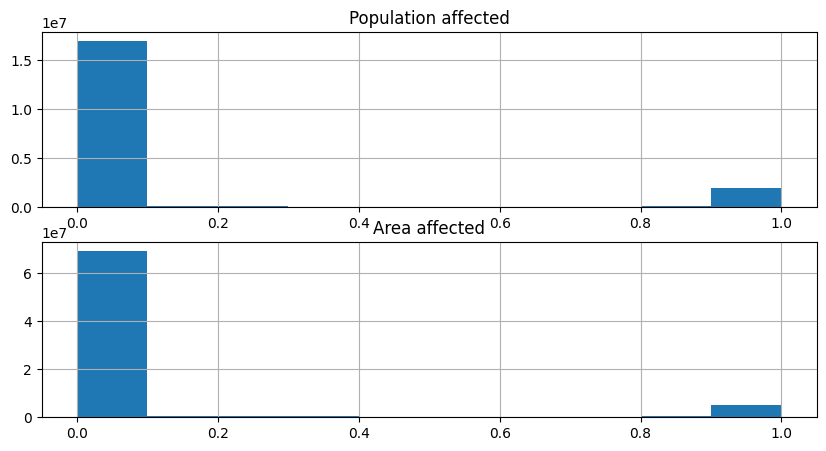

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
sums.population_affected.hist(ax=ax[0])
sums.area_affected.hist(ax=ax[1])

ax[0].set_title("Population affected")
ax[1].set_title("Area affected")

In [25]:
df

cells_affected  total_cells  population_affected_n  \
ID      name    year                                                       
0.0     spei110 1970               0           24                      0   
                1971               0           24                      0   
                1972               0           24                      0   
                1973               0           24                      0   
                1974               0           24                      0   
...                              ...          ...                    ...   
38149.0 spi625  2016               0           62                      0   
                2017               0           62                      0   
                2018               0           62                      0   
                2019               0           62                      0   
                2020               0           62                      0   

                      total_population  area_affected  population_affected  
ID      name    year                                                        
0.0     spei110 1970                 0            0.0                  NaN  
                1971                 0            0.0                  NaN  
                1972                 0            0.0                  NaN  
                1973                 0            0.0                  NaN  
                1974                 0            0.0                  NaN  
...                                ...            ...                  ...  
38149.0 spi625  2016             77778            0.0                  0.0  
                2017             77778            0.0                  0.0  
                2018             91329            0.0                  0.0  
                2019             91329            0.0                  0.0  
                2020             91329            0.0                  0.0  

[77750520 rows x 6 columns]

In [ ]:
sums = df.drop(columns=["cells_affected", "total_cells", "population_affected_n", "total_population"])
sums = sums.fillna(0)
sums = sums.reset_index()

In [28]:
dfs = []
df = []

In [30]:
sums_pivot = sums.pivot(index=["ID", "year"], columns="name", values=["population_affected", "area_affected"])

In [58]:
import re
def parse_columns(names: tuple):
    agg = names[0]
    string = names[1]
    
    letter = agg[0]
    match = re.match(r"([a-zA-Z]+)(\d+)", string)
    if match:
        return f"{match.group(1)}{letter}{match.group(2)}"
    else:
        raise ValueError("The input string does not match the expected pattern.")

In [77]:
newcols = []
for cols in sums_pivot.columns:
    newcols += [parse_columns(cols)]
    
sums_pivot.columns = newcols    
sums_pivot = sums_pivot.reset_index()

In [101]:
out_df = gdf.merge(sums_pivot, left_on="id", right_on="ID", validate="1:m", how="outer")

In [103]:
out_df.rename(columns={
    "adm0_code": "adm0",
    "admlast_code": "adm_lst",
    }, inplace=True)

In [110]:
DATA_OUT = "Z:\Laboral\World Bank\CLIENT v2\Data\Data_out"
out_df = out_df[["adm0", "adm_lst", "year", "ID"] + newcols]
for country in out_df.adm0.unique():
    out_df[out_df.adm0 == country].to_stata(os.path.join(DATA_OUT, f"drought_{country}.dta"))


,adm0,adm_lst,year,ID,speip110,speip115,speip120,speip1210,speip1215,speip1220,...,spia2420,spia2425,spia310,spia315,spia320,spia325,spia610,spia615,spia620,spia625
84409,12,4379.0,1970,1659.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84410,12,4379.0,1971,1659.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84411,12,4379.0,1972,1659.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84412,12,4379.0,1973,1659.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84413,12,4379.0,1974,1659.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909421,12,190526.0,2016,37475.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909422,12,190526.0,2017,37475.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909423,12,190526.0,2018,37475.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1909424,12,190526.0,2019,37475.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
